# PI-Deeponet

$$\frac{\partial s}{\partial t} = D_{coeff}\frac{\partial^2 s}{\partial x^2} + K_{coeff}s^2 + u(x)$$\
$$s(x,0) = 0$$


boundary condition: periodic\
$domain$ : $$x = [0,1],t = [0,1]$$

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, concatenate, Lambda
from tensorflow.keras.utils import to_categorical
import scipy.io
import time as time_lib
import scipy.optimize
from scipy.fft import fft, ifft
from scipy.integrate import odeint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##Training Data preparation

In [43]:
n_functions=50 #no of functions
n_sensors=100 #no of sensor points

lb_A=-1 #lowerbound of coefficient
ub_A=1 #upperbound of coefficient
L=1
nx = 50 # no of grid points for x
nt = 50 # no of grid points for t

n_bdr=400
n_train=nx*nt

# domain
x_0=0
x_l=1
t_0=0
t_l=1

#for trunck-inside points
x=np.linspace(x_0,x_l,nx)
t=np.linspace(t_0,t_l,nt)

#boundary points 1 (t=0)
x_bdr=np.random.rand(n_bdr)
t_bdr=np.zeros(n_bdr)

#boundary points 2 (x=0 and x=L)
x_bdr2=np.zeros(n_bdr)
t_bdr2=np.random.rand(n_bdr)

#for trunck
x_sensor=np.linspace(0,1,n_sensors)

t=np.reshape(t,(len(t),1))
x=np.reshape(x,(len(x),1))

x_eval,t_eval = np.meshgrid(x,t)
x_eval=np.reshape(x_eval,-1)
t_eval=np.reshape(t_eval,-1)

x_bdr=np.reshape(x_bdr,-1)
t_bdr=np.reshape(t_bdr,-1)

x_bdr2=np.reshape(x_bdr2,-1)
t_bdr2=np.reshape(t_bdr2,-1)

y=np.concatenate([x_eval[:, None], t_eval[:, None]],axis=1)
y_bdr=np.concatenate([x_bdr[:, None], t_bdr[:, None]],axis=1)
y_bdr2=np.concatenate([x_bdr2[:, None], t_bdr2[:, None]],axis=1)

A=np.random.rand(n_functions)
B=np.random.rand(n_functions)

D_coeff  = 0.01 # constant in PDE
K_coeff = 0.01 # constant in PDE

#functions
def fn(A,B,x):
    return np.cos(2*np.pi*A*x)+np.sin(2*np.pi*B*x)+A*np.e**(-A*x)-B*np.e**(B*x)+np.log(1+A)+B*A*np.log(1+A*B)#+(A*B*x**2+x+B+A*B**2)**2+A*x+B*x**2+A+B
#DNS
def sol_reaction_diff(u,t,K_coeff,D_coeff):

    s_0 = u*0.0

    def rhsf(s, t):
        N = len(s)
        n = np.arange(N); n[int(N/2)+1:]-= N
        return K_coeff*s**2 - D_coeff*ifft((2*np.pi*n/L)**2*fft(s)).real + u
    sol = odeint(rhsf, s_0, t)

    return sol

f=[]
for i in range(n_functions):
    f.append(fn(A[i],B[i],x_sensor))

f=np.array(f)

In [44]:
f.shape

(50, 100)

In [45]:
#create X_train

#x_branch and x_branch to train
X_train_branch=[]
X_train_trunck=[]
A_train=[]
B_train=[]

for i in range(n_functions):
    for j in range(n_train):
        X_train_branch.append(f[i])
        X_train_trunck.append(y[j])

        A_train.append(A[i])
        B_train.append(B[i])

X_train_branch=np.array(X_train_branch)
X_train_trunck=np.array(X_train_trunck)

A_train=np.array(A_train)
B_train=np.array(B_train)

#create X_train for boundary (t=0)

#x_branch and x_branch to train
X_train_branch_bdr=[]
X_train_trunck_bdr=[]
A_train_bdr=[]
B_train_bdr=[]

for i in range(n_functions):
    for j in range(n_bdr):
        X_train_branch_bdr.append(f[i])
        X_train_trunck_bdr.append(y_bdr[j])

        A_train_bdr.append(A[i])
        B_train_bdr.append(B[i])

X_train_branch_bdr=np.array(X_train_branch_bdr)
X_train_trunck_bdr=np.array(X_train_trunck_bdr)

A_train_bdr=np.array(A_train_bdr)
B_train_bdr=np.array(B_train_bdr)

#create X_train for boundary(x=0 )

#x_branch and x_branch to train
X_train_branch_bdr2=[]
X_train_trunck_bdr2=[]
A_train_bdr2=[]
B_train_bdr2=[]

for i in range(n_functions):
    for j in range(n_bdr):
        X_train_branch_bdr2.append(f[i])
        X_train_trunck_bdr2.append(y_bdr2[j])

        A_train_bdr2.append(A[i])
        B_train_bdr2.append(B[i])

X_train_branch_bdr2=np.array(X_train_branch_bdr2)
X_train_trunck_bdr2=np.array(X_train_trunck_bdr2)

A_train_bdr2=np.array(A_train_bdr2)
B_train_bdr2=np.array(B_train_bdr2)

In [46]:
X_train_br=tf.convert_to_tensor(X_train_branch, dtype=tf.float32, dtype_hint=None, name=None)
X_train_tr=tf.convert_to_tensor(X_train_trunck, dtype=tf.float32, dtype_hint=None, name=None)
A_train=tf.convert_to_tensor(A_train, dtype=tf.float32, dtype_hint=None, name=None)
B_train=tf.convert_to_tensor(B_train, dtype=tf.float32, dtype_hint=None, name=None)

X_train_br_bdr=tf.convert_to_tensor(X_train_branch_bdr, dtype=tf.float32, dtype_hint=None, name=None)
X_train_tr_bdr=tf.convert_to_tensor(X_train_trunck_bdr, dtype=tf.float32, dtype_hint=None, name=None)
A_train_bdr=tf.convert_to_tensor(A_train_bdr, dtype=tf.float32, dtype_hint=None, name=None)
B_train_bdr=tf.convert_to_tensor(B_train_bdr, dtype=tf.float32, dtype_hint=None, name=None)

X_train_br_bdr2=tf.convert_to_tensor(X_train_branch_bdr2, dtype=tf.float32, dtype_hint=None, name=None)
X_train_tr_bdr2=tf.convert_to_tensor(X_train_trunck_bdr2, dtype=tf.float32, dtype_hint=None, name=None)
A_train_bdr2=tf.convert_to_tensor(A_train_bdr2, dtype=tf.float32, dtype_hint=None, name=None)
B_train_bdr2=tf.convert_to_tensor(B_train_bdr2, dtype=tf.float32, dtype_hint=None, name=None)

In [47]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_br, X_train_tr, A_train,B_train))
dataset_bdr=tf.data.Dataset.from_tensor_slices((X_train_br_bdr, X_train_tr_bdr, A_train_bdr,B_train_bdr))
dataset_bdr2=tf.data.Dataset.from_tensor_slices((X_train_br_bdr2, X_train_tr_bdr2, A_train_bdr2,B_train_bdr2))

batch_size = 25000  # Adjust this based on needs
batch_size_bdr = 4000
batch_size_bdr2 = 4000

dataset = dataset.batch(batch_size)
dataset_bdr = dataset_bdr.batch(batch_size_bdr)
dataset_bdr2 = dataset_bdr2.batch(batch_size_bdr2)

## DeepOnet mdoel Architecture and PINN Loss

In [48]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam()
tf.keras.backend.set_floatx('float32')

#model for deepOnet###########################################################

#no of sensor points
m=n_sensors
branch_input = Input(shape=(m,), name='vector_input')
trunck_input = Input(shape=(2,), name='scalar_input')

#branch network
branch_net = Dense(128, activation='tanh')(branch_input)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(m, activation='tanh')(branch_net)

# Trunck network
trunck_net = Dense(128, activation='tanh')(trunck_input)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(m, activation='tanh')(trunck_net)
#bias = tf.Variable(0., shape=(), trainable=True)

dot_product = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True))([branch_net, trunck_net])
model = tf.keras.Model(inputs=[branch_input, trunck_input], outputs=dot_product)

############################# Loss Functions ##################################################

def loss(X_br,X_tr,A,B):
    with tf.GradientTape(persistent=True) as tape:

            x,t=tf.unstack(X_tr,axis=1)
            tape.watch(x)
            tape.watch(t)

            s = model([X_br, tf.stack((x,t),axis=1)], training=True)
            dsdx=tape.gradient(s,x)
            d2sdx2=tape.gradient(dsdx,x)

            dsdt=tape.gradient(s,t)
            u=fn(A,B,x)

            loss = tf.reduce_mean(tf.square(dsdt-D_coeff*d2sdx2-K_coeff*tf.square(s)-u))

    return loss

def loss_bdr(X_br,X_tr,A,B):
    with tf.GradientTape(persistent=True) as tape:

            x,t=tf.unstack(X_tr,axis=1)
            tape.watch(x)
            tape.watch(t)

            s = model([X_br, tf.stack((x,t),axis=1)], training=True)
            dsdx=tape.gradient(s,x)
            d2sdx2=tape.gradient(dsdx,x)

            dsdt=tape.gradient(s,t)
            u=fn(A,B,x)

            loss2=tf.reduce_mean(tf.square(s))#initial loss
            loss = tf.reduce_mean(tf.square(dsdt-D_coeff*d2sdx2-K_coeff*tf.square(s)-u))#equation loss

    return (loss+loss2)/2

def loss_bdr2(X_br,X_tr,A,B):
    with tf.GradientTape(persistent=True) as tape:

            x,t=tf.unstack(X_tr,axis=1)
            xl=x+L
            tape.watch(x)
            tape.watch(t)
            tape.watch(xl)
            
            s = model([X_br, tf.stack((x,t),axis=1)], training=True)
            s1 = model([X_br, tf.stack((xl,t),axis=1)], training=True)
            
            dsdx=tape.gradient(s,x)
            d2sdx2=tape.gradient(dsdx,x)
            
            ds1dx=tape.gradient(s1,xl)
            d2s1dx2=tape.gradient(ds1dx,xl)

            dsdt=tape.gradient(s,t)
            ds1dt=tape.gradient(s1,t)
            
            u=fn(A,B,x)
            
            loss_bdr=tf.reduce_mean(tf.square(s-s1))
            loss_bdr_2=tf.reduce_mean(tf.square(dsdx-ds1dx))
            
            loss1 = tf.reduce_mean(tf.square(dsdt-D_coeff*d2sdx2-K_coeff*tf.square(s)-u))#equation loss at x=0
            loss2 = tf.reduce_mean(tf.square(ds1dt-D_coeff*d2s1dx2-K_coeff*tf.square(s1)-u))#equation loss at x=L
            
            
    return (loss_bdr+loss_bdr_2)/4

##Training LOOP

In [62]:
# Training loop

# Define a learning rate schedule
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9)

# Define the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_total=[]
epochs=[]
for epoch in range(600):
    for X_br, X_tr, A,B in dataset:
        with tf.GradientTape() as tape:

            loss_value = loss(X_br,X_tr,A,B)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    for X_br, X_tr, A,B in dataset_bdr:
        with tf.GradientTape() as tape:

            loss_value_bdr = loss_bdr(X_br,X_tr,A,B)
        grads = tape.gradient(loss_value_bdr, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    #loss_total.append(loss_value+loss_value_bdr)
    #epochs.append(epoch)
    '''
    for X_br, X_tr, A,B in dataset_bdr2:
        with tf.GradientTape() as tape:
            loss_value_bdr2 = loss_bdr2(X_br,X_tr,A,B)
        grads = tape.gradient(loss_value_bdr2, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
       ''' 
    loss_total_f=loss_value+loss_value_bdr#+loss_value_bdr2
    loss_total.append(loss_total_f)
    epochs.append(epoch)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss={loss_total_f:.6f}")
    #print(f"Epoch {epoch}, loss={loss_value:.6f}", end='\r')

Epoch 0, loss=0.548483
Epoch 100, loss=0.010208
Epoch 200, loss=0.005242
Epoch 300, loss=0.004056
Epoch 400, loss=0.003632
Epoch 500, loss=0.003450
Epoch 600, loss=0.003366
Epoch 700, loss=0.003327


KeyboardInterrupt: 

##Error plot

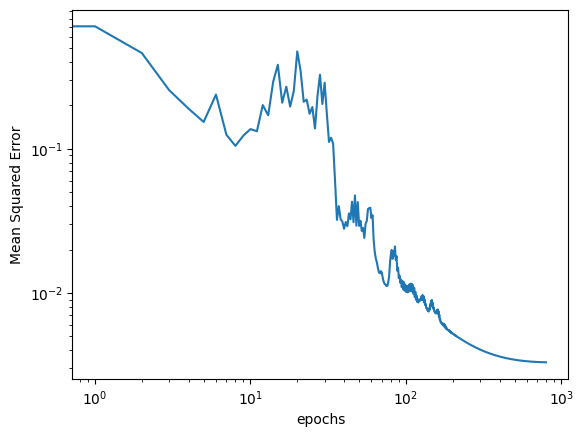

In [63]:
plt.xlabel('epochs')
plt.ylabel('Mean Squared Error')
plt.loglog(epochs,loss_total)

##Testing on new functions

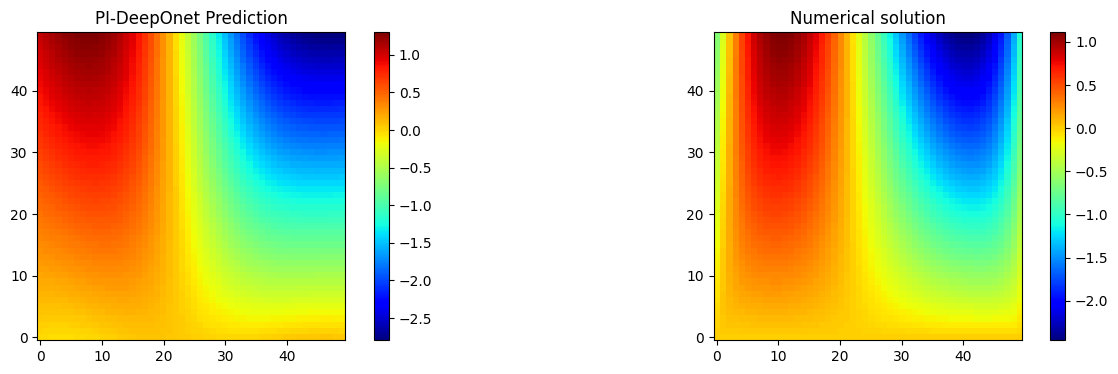

In [72]:
#prediction for a-new function, test new data preparation
A_new=np.random.rand()
B_new=np.random.rand()
X_test_branch=[]
X_test_trunck=[]

f_new=fn(A_new,B_new,x_sensor)
for i in range(1):
    for j in range(n_train):
        X_test_branch.append(f_new)
        X_test_trunck.append(y[j])

#testing data
X_test_branch=np.array(X_test_branch)
X_test_trunck=np.array(X_test_trunck)

#new unseen function pred
s=model([X_test_branch, X_test_trunck])
pred=tf.reshape(s,(nx,nt))

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# First set of plots
ax1 = axes[0]
ax1.set_title('PI-DeepOnet Prediction')
im1 = ax1.imshow(pred, cmap='jet', origin='lower')
fig.colorbar(im1, orientation='vertical')

# Second set of plots
ax2 = axes[1]
ax2.set_title('Numerical solution')
x = np.linspace(0, 1, nx)
t = np.linspace(0, 1, nt)
u_inp_fun = fn(A_new, B_new, x)
sol_fun = sol_reaction_diff(u_inp_fun, t, K_coeff, D_coeff)
im2 = ax2.imshow(sol_fun, cmap='jet', origin='lower')
fig.colorbar(im2, orientation='vertical')

plt.show()

##Mean Squared error of the PI-DeepOnet solution for the new function

In [73]:
np.mean((pred-sol_fun)**2)

0.09365232

##**R2 Scores of the prediction**

In [74]:
r2=1-(np.sum((pred-sol_fun)**2)/(np.sum((sol_fun-np.mean(sol_fun))**2)))
print(r2)

0.8580432659574999


##Test on 1000 new functions

0.0


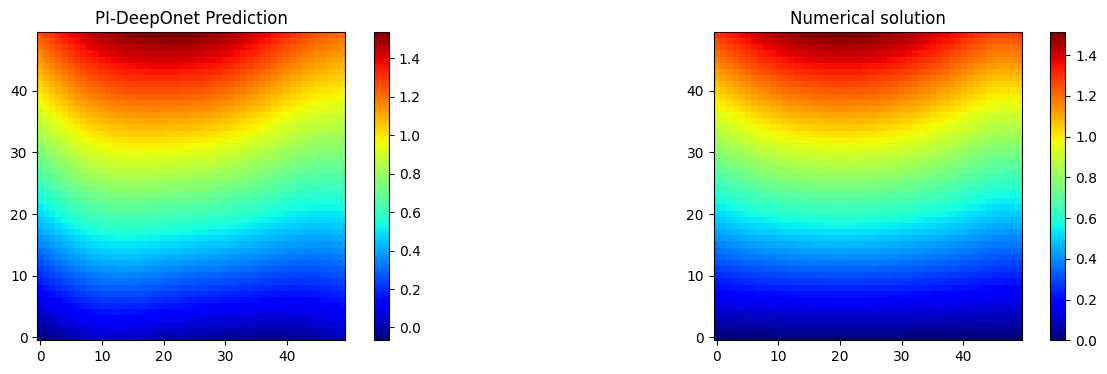

1.0


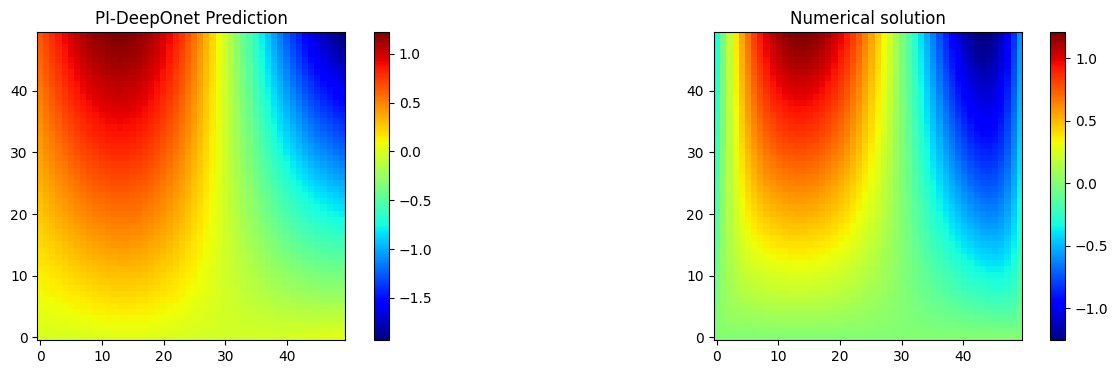

2.0


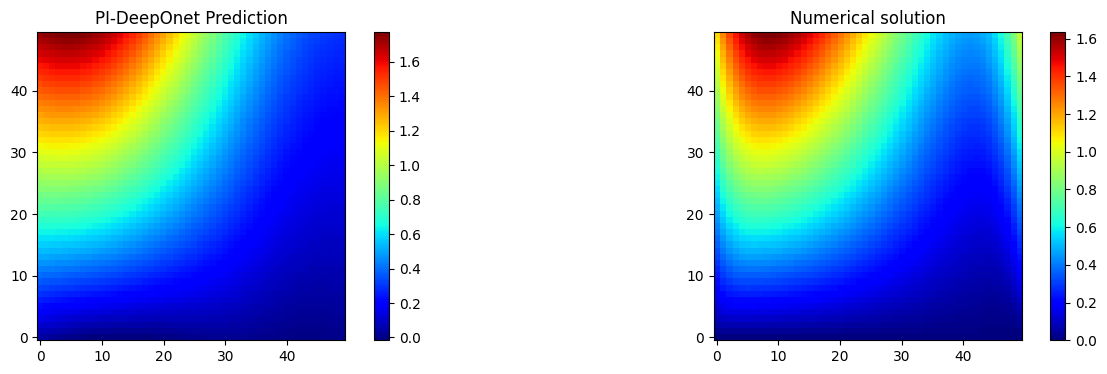

3.0


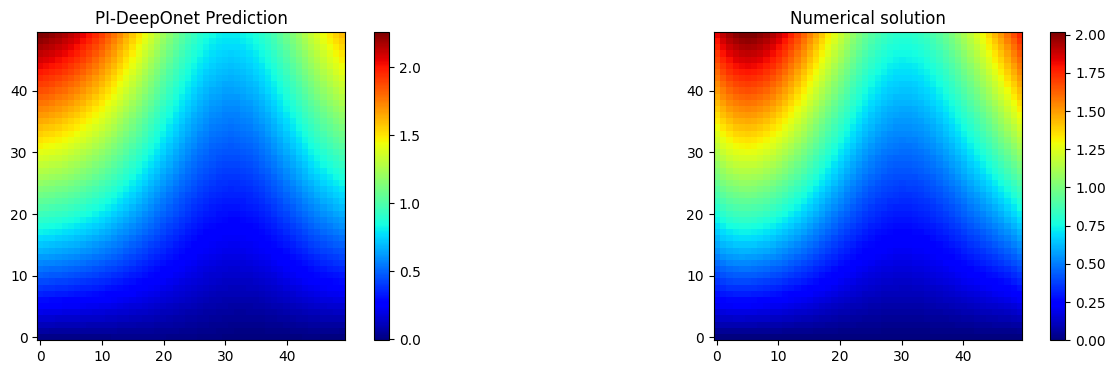

4.0


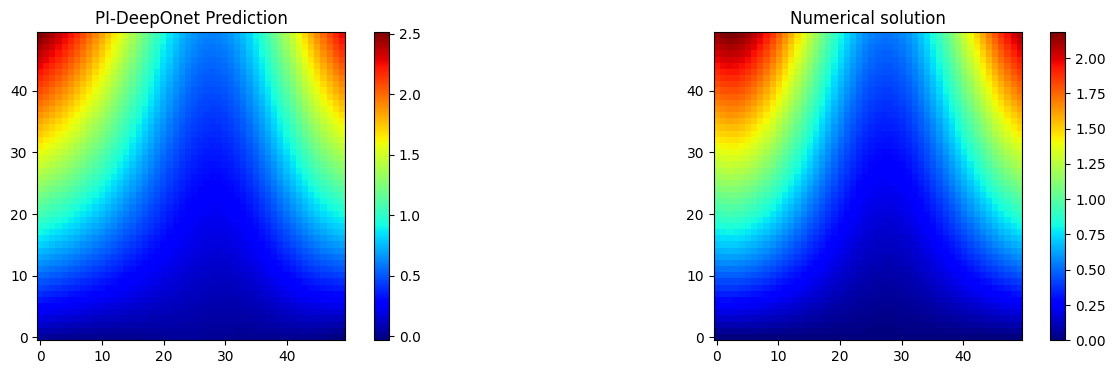

5.0


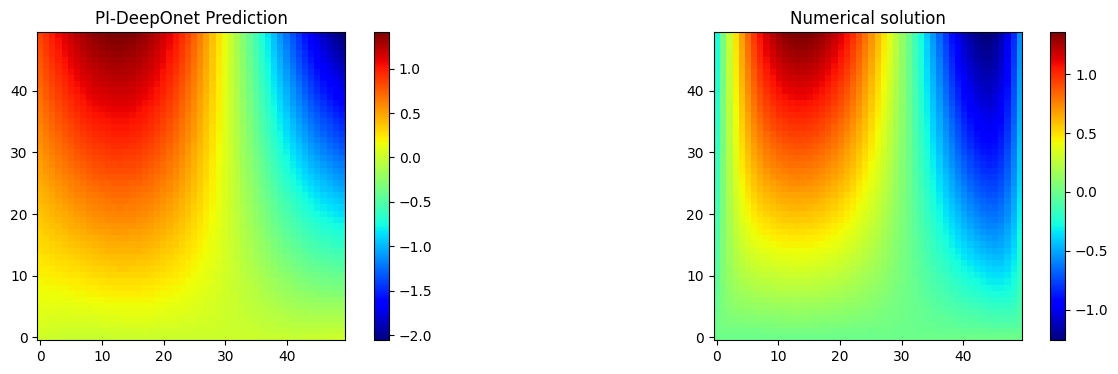

6.0


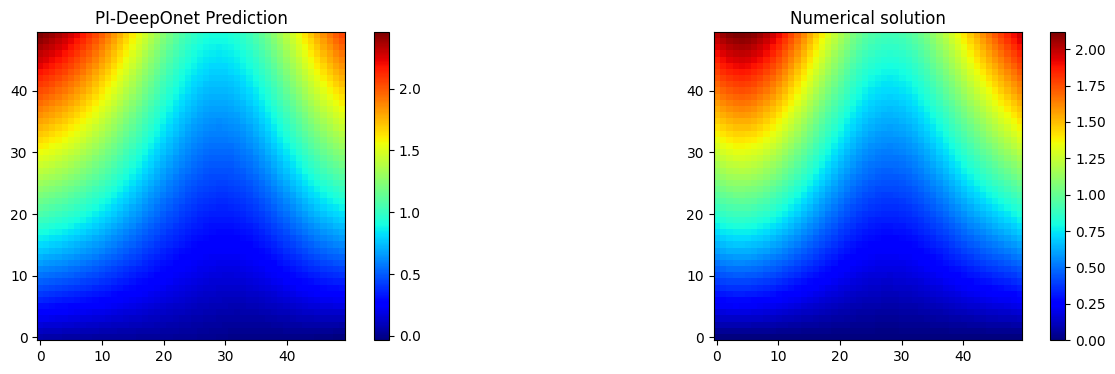

7.0


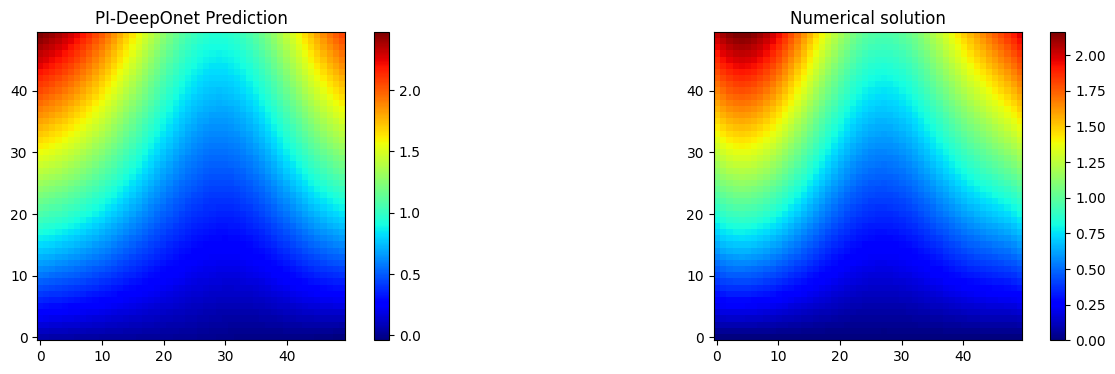

8.0


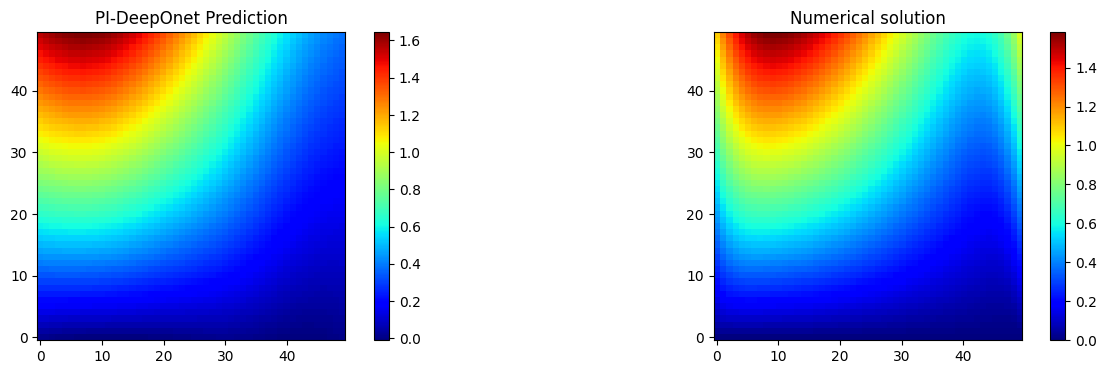

9.0


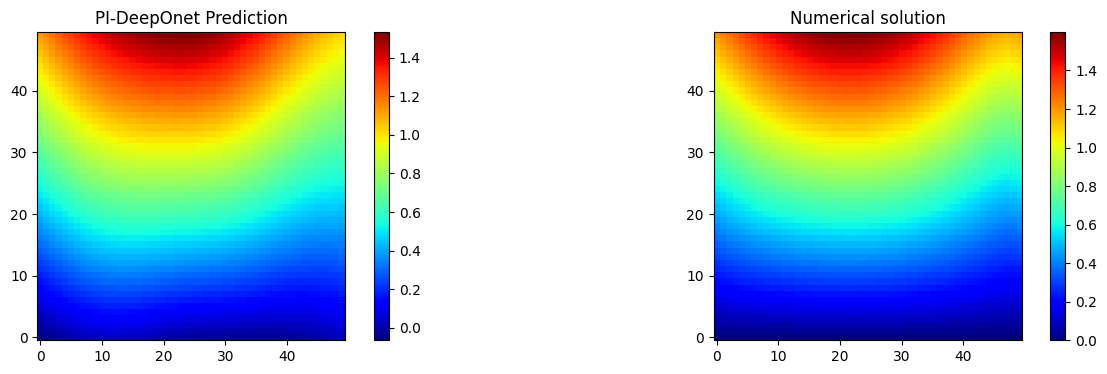

In [77]:
r2_scores=[]
for i in range(250):
    A_new=np.random.rand()
    B_new=np.random.rand()
    X_test_branch=[]
    X_test_trunck=[]

    f_new=fn(A_new,B_new,x_sensor)
    for k in range(1):
        for j in range(n_train):
            X_test_branch.append(f_new)
            X_test_trunck.append(y[j])

      #testing data
    X_test_branch=np.array(X_test_branch)
    X_test_trunck=np.array(X_test_trunck)

      #new unseen function pred
    s=model([X_test_branch, X_test_trunck])
    pred=tf.reshape(s,(nx,nt))

  #numerical sol for the test function
    x=np.linspace(0,1,nx)
    t=np.linspace(0,1,nt)
    u_inp_fun=fn(A_new,B_new,x)
    sol_fun =  sol_reaction_diff(u_inp_fun,t,K_coeff,D_coeff)
    r2=1-(np.sum((pred-sol_fun)**2)/(np.sum((sol_fun-np.mean(sol_fun))**2)))
    r2_scores.append(r2)
    
    if(i%25==0):
        print(i/25)
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))

        # First set of plots
        ax1 = axes[0]
        ax1.set_title('PI-DeepOnet Prediction')
        im1 = ax1.imshow(pred, cmap='jet', origin='lower')
        fig.colorbar(im1, orientation='vertical')

        # Second set of plots
        ax2 = axes[1]
        ax2.set_title('Numerical solution')
        x = np.linspace(0, 1, nx)
        t = np.linspace(0, 1, nt)
        u_inp_fun = fn(A_new, B_new, x)
        sol_fun = sol_reaction_diff(u_inp_fun, t, K_coeff, D_coeff)
        im2 = ax2.imshow(sol_fun, cmap='jet', origin='lower')
        fig.colorbar(im2, orientation='vertical')

        plt.show()

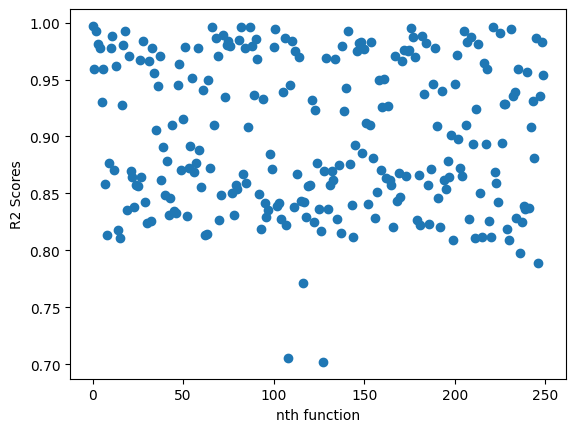

In [78]:
plt.xlabel('nth function')
plt.ylabel('R2 Scores')
plt.scatter(np.arange(len(r2_scores)),r2_scores)

In [79]:
#observation-mean r2 score increases with #of functions
avg_r2=np.sum(np.array(r2_scores))/len(r2_scores)
print(avg_r2)

0.9002001076934771


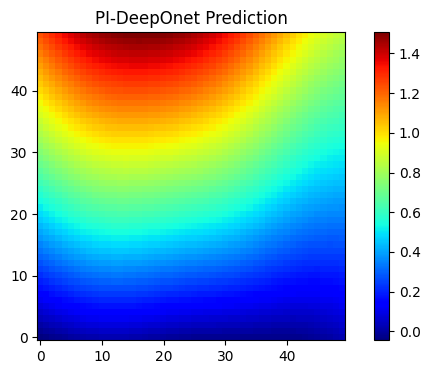

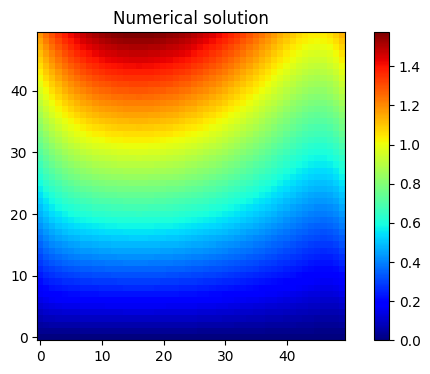

In [82]:
def new_fn(A,B,x):
    return A*x+B*x**2+A+B**2

#prediction for a-new function, test new data preparation
A_new=np.random.rand()
B_new=np.random.rand()
X_test_branch=[]
X_test_trunck=[]

f_new=fn(A_new,B_new,x_sensor)
for i in range(1):
    for j in range(n_train):
        X_test_branch.append(f_new)
        X_test_trunck.append(y[j])

#testing data
X_test_branch=np.array(X_test_branch)
X_test_trunck=np.array(X_test_trunck)

#new unseen function pred
s=model([X_test_branch, X_test_trunck])
pred=tf.reshape(s,(nx,nt))

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax1.set_title('PI-DeepOnet Prediction')
im1 = ax1.imshow(pred,cmap='jet',origin='lower')
fig.colorbar(im1, orientation='vertical')

#numerical sol for the test function
x=np.linspace(0,1,nx)
t=np.linspace(0,1,nt)
u_inp_fun=fn(A_new,B_new,x)
sol_fun =  sol_reaction_diff(u_inp_fun,t,K_coeff,D_coeff)

#plot the results
fig2 = plt.figure(figsize=(16,4))
ax2 = fig2.add_subplot(121)
ax2.set_title('Numerical solution')
im2 = ax2.imshow(sol_fun,cmap='jet',origin='lower')
fig2.colorbar(im2, orientation='vertical')
plt.show()

In [83]:
r2=1-(np.sum((pred-sol_fun)**2)/(np.sum((sol_fun-np.mean(sol_fun))**2)))
print(r2)

0.9889277911988479


In [84]:
#add different types of fnx in training
#PINN comparision